In [1]:
import MySQLdb, pickle
import pandas as pd
from sqlalchemy import create_engine
from collections import Counter

In [2]:
# read local car_info popular 
pw = pickle.load(open('./Data/pw.plk','rb'))

db = MySQLdb.connect(
    "127.0.0.1",
    "root",
    pw,
    "used_car",
    charset='utf8',
)

SQL_QUERY = """
    SELECT *
    FROM used_car;
"""

train = pd.read_sql(SQL_QUERY, db)
train.head(20)

,index,year,title,brand,model,miles,photos,video,exterior_color,interior_color,transmission,drivetrain,star,review_no,vendor,price
0,0,2003,mazda tribute lx v6,mazda,tribute,118205,21,1,silver,gray,4-speed,fwd,5,43,1st choice autos,3750
1,1,2016,subaru crosstrek 2.0i,subaru,crosstrek,26525,23,1,desert,black,5-speed,4wd,5,43,1st choice autos,17999
2,2,2018,ford f-150 raptor,ford,f-150,2330,32,1,race,black,10-speed,4wd,5,244,gilbert & baugh ford,53900
3,3,2015,lexus rc f,lexus,rc,27080,23,1,black,red,8-speed,rwd,5,6,carmax south boulevard,43998
4,4,2014,mercedes-benz s 550,mercedes-benz,s,121078,32,1,palladium,silk beige,7-speed,rwd,5,939,hendrickbmw,32991
5,5,2016,mercedes-benz gl 63 amg 4matic,mercedes-benz,gl,17582,32,1,black,auburn brown,7-speed,4wd,5,19,global motorsports inc.,79895
6,6,2017,infiniti q50 3.0t premium,infiniti,q50,31736,26,1,platinum,black,7-speed,rwd,5,18,hertz car sales winston-salem,19998
7,7,2016,jeep compass latitude,jeep,compass,46644,25,1,granite,dark slate,6-speed,fwd,5,90,hertz car sales orlando,11488
8,8,2008,subaru outback,subaru,outback,199532,29,1,gray,gray,6-speed,4wd,5,16,sharpmotors,3950
9,9,2016,tesla model x p90d,tesla,model,17342,32,1,black,black,1-speed,4wd,5,96,bayshoreautomotive,104890


In [3]:
brand_list = []
for brand in Counter(train.brand).most_common(30):
    brand_list.append(brand[0])

In [4]:
idx_list = []
idx = 0
for i in train["brand"]:
    if i not in brand_list:
        idx_list.append(idx)
    idx += 1

In [5]:
train.shape

(4997, 16)

In [6]:
train = train.drop(idx_list)
train.reset_index(drop=True, inplace=True)
train = train.drop("index", axis=1)

Feature engineering

In [7]:
categorical_features = ['brand', 'model']

In [8]:
dummy_cat = pd.get_dummies(train[categorical_features])
dummy_cat.head()

,brand_acura,brand_audi,brand_bmw,brand_buick,brand_cadillac,brand_chevrolet,brand_chrysler,brand_dodge,brand_ford,brand_gmc,...,model_xf,model_xj,model_xk,model_xt5,model_xterra,model_xts,model_xv,model_yaris,model_yukon,model_z4
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
numerical_features = ['year', 'miles','price']

In [10]:
normalize_num = np.log1p(train[numerical_features])
normalize_num.head()

,year,miles,price
0,7.602900,11.680184,8.229778
1,7.609367,10.185881,9.798127
2,7.610358,7.754053,10.894904
3,7.608871,10.206588,10.691922
4,7.608374,11.704199,10.404020


In [11]:
# pre_train = pd.merge(normalize_num, dummy_cat) 
X_train_0 = normalize_num.join(dummy_cat)
y_train = X_train_0["price"]
X_train = X_train_0.drop("price", axis=1)

In [12]:
from xgboost import XGBRegressor
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

k_fold = KFold(n_splits=10, shuffle=True, random_state=2018)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train)

/Users/sunghwanki/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
ml = XGBRegressor(n_estimators=1000, learning_rate=0.05, verbose=False)

In [14]:
%time score = cross_val_score(ml, X_train, y_train, cv=k_fold, n_jobs=-1, scoring="r2").mean()

print("Score = {0:.5f}".format(score))

CPU times: user 197 ms, sys: 67.1 ms, total: 264 ms
Wall time: 2min 17s
Score = 0.83457


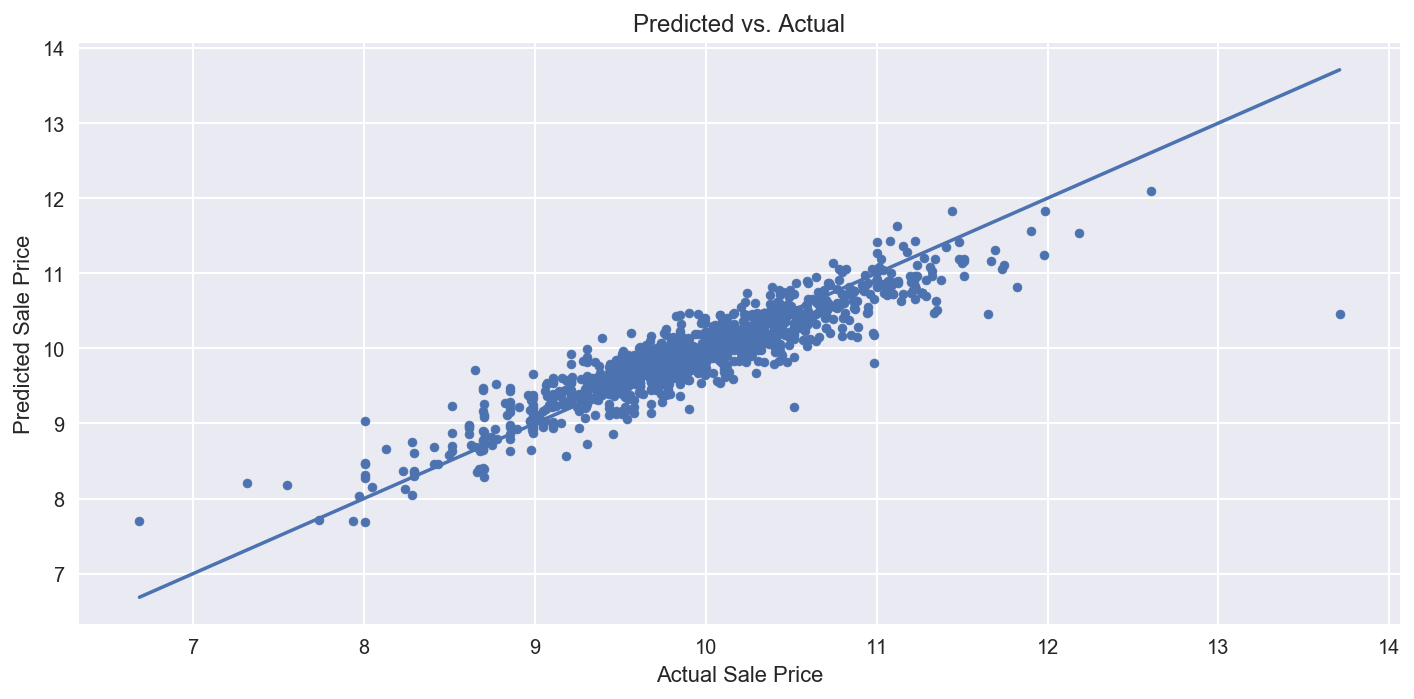

In [15]:
ml = ml.fit(X_train1, y_train1)
y_pred = ml.predict(X_test1)

plt.figure(figsize=(10, 5))
plt.scatter(y_test1, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test1), max(y_test1)], [min(y_test1), max(y_test1)])
plt.tight_layout()

In [16]:
pickle.dump(ml, open("./Flask/models/model.plk","wb"))

In [17]:
actual_car_info = train[["brand", "model","year","miles","price"]]
pickle.dump(actual_car_info, open("./Flask/models/actual_car_info.plk","wb"))

In [18]:
brand = str(input("brand: "))
model = str(input("model: "))
year = int(input("year: "))
miles = int(input("miles: "))

brand: kia
model: optima
year: 2010
miles: 35000


In [19]:
target = pd.DataFrame(columns = [X_train1.columns])

In [20]:
pickle.dump(X_train1.columns, open("./Flask/models/column.plk","wb"))

In [21]:
cdx = 0
for col in X_train.columns:
    if col == 'brand'+"_"+brand:
        break;
    cdx += 1
cdx

17

In [22]:
sdx = 0
for col in X_train.columns:
    if col == 'model'+"_"+model:
        break;
    sdx += 1
sdx

302

In [23]:
target_list = np.zeros_like(X_train.loc[0])

In [24]:
pickle.dump(target_list, open("./Flask/models/target_list.plk","wb"))

In [25]:
target_list[cdx] = 1
target_list[sdx] = 1
target_list[0] = year
target_list[1] = miles

In [26]:
for i in range(1):
    target.loc[i] = target_list

In [27]:
target

,year,miles,brand_acura,brand_audi,brand_bmw,brand_buick,brand_cadillac,brand_chevrolet,brand_chrysler,brand_dodge,...,model_xf,model_xj,model_xk,model_xt5,model_xterra,model_xts,model_xv,model_yaris,model_yukon,model_z4
0,2010.0,35000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
numerical_features = ['year', 'miles']
target[numerical_features] = np.log1p(target[numerical_features])

In [29]:
target

,year,miles,brand_acura,brand_audi,brand_bmw,brand_buick,brand_cadillac,brand_chevrolet,brand_chrysler,brand_dodge,...,model_xf,model_xj,model_xk,model_xt5,model_xterra,model_xts,model_xv,model_yaris,model_yukon,model_z4
0,7.606387,10.463132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
price_log = ml.predict(target)

In [31]:
price_log

array([ 9.34082317], dtype=float32)

In [32]:
price = np.exp(price_log)
print("Price:", int(price))

Price: 11393


In [33]:
same_model = actual_car_info[actual_car_info["model"]==model] 
year_price = same_model[["year", "price"]]
year_price_list = year_price.groupby("year").agg({'price':np.mean}).astype('int')
year_price_list = year_price_list.reset_index()
year_price_list

,year,price
0,2011,9953
1,2012,9856
2,2013,11285
3,2014,12945
4,2015,14393
5,2016,14925
6,2017,18514


In [46]:
year_price_list["year"] = year_price_list["year"].apply(lambda x: str(x) )

In [47]:
year_price_list["price"] = year_price_list["price"].apply(lambda x: str(x) )

In [38]:
list(year_price_list["price"])

[9953, 9856, 11285, 12945, 14393, 14925, 18514]